In [293]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os
from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# lectura de datasets

In [130]:
df_clima = pd.read_csv("nasa_power_llaca_1990_2024.csv", skiprows=21)
df_sensor = pd.read_csv("sensor_and_environmental_data_10min_2020_2025.csv")
df_directo = pd.read_csv("monitoreo_directo_dummy.csv")
df_indirecto = pd.read_csv("monitoreo_indirecto_dummy.csv")

# Analsis y pre procesamiento de las fuentes de datos

## Analisis data de la nasa

In [164]:
df_clima.head()

,YEAR,MO,DY,WS2M,ALLSKY_SFC_LW_DWN,T2M_MAX,CLRSKY_SFC_SW_DWN,CLOUD_AMT,QV2M,RH2M,T2M_MIN,T2MDEW,TS,T2M,ALLSKY_SFC_SW_DWN,PRECTOTCORR
0,1990,1,1,1.76,289.72,17.50,343.98,59.3,6.90,67.51,3.17,1.83,11.79,8.51,254.75,0.31
1,1990,1,2,1.52,303.77,17.00,340.17,78.4,6.43,61.18,2.84,0.75,12.29,8.67,263.99,0.13
2,1990,1,3,1.83,310.26,15.62,349.72,95.2,7.28,71.10,3.83,2.60,10.96,7.91,228.31,0.08
3,1990,1,4,1.39,305.74,13.97,347.50,85.5,6.96,69.95,3.19,1.94,10.07,7.37,222.78,0.29
4,1990,1,5,1.53,307.37,15.85,355.80,93.1,6.17,60.47,2.62,0.09,10.66,7.82,194.92,0.02


In [165]:
df_clima['DATE'] = pd.to_datetime(df_clima[['YEAR', 'MO', 'DY']].rename(columns={
    'YEAR': 'year', 'MO': 'month', 'DY': 'day'
}))

df_clima = df_clima[['DATE'] + [col for col in df_clima.columns if col not in ['DATE']]]

### renombrado de columnas

In [166]:
mapping = {
    'DATE': 'Fecha',
    'YEAR': 'Año',
    'MO': 'Mes',
    'DY': 'Dia',
    'WS2M': 'Velocidad_viento_2m',
    'ALLSKY_SFC_LW_DWN': 'Radiacion_onda_larga_superficie',
    'T2M_MAX': 'Temperatura_máxima_2m',
    'CLRSKY_SFC_SW_DWN': 'Radiacion_cielo_despejado',
    'CLOUD_AMT': 'Cobertura_nubosa',
    'QV2M': 'Humedad_específica_2m',
    'RH2M': 'Humedad_relativa_2m',
    'T2M_MIN': 'Temperatura_minima_2m',
    'T2MDEW': 'Temperatura_punto_de_rocio',
    'TS': 'Temperatura_superficie',
    'T2M': 'Temperatura_2m',
    'ALLSKY_SFC_SW_DWN': 'Radiacion_solar_superficie',
    'PRECTOTCORR': 'Precipitacion_total_corregida'
}

# Renombrar columnas
df_clima = df_clima.rename(columns=mapping)

In [167]:
# Convertir variables a numérico (evita errores de lectura)
for col in df_clima.columns:
    if col not in ['Fecha', 'año', 'Mes', 'Dia']:
        df_clima[col] = pd.to_numeric(df_clima[col], errors='coerce')

In [168]:
nulos_por_col = df_clima.isnull().sum()
print("Nulos por columna:")
print(nulos_por_col)

Nulos por columna:
Fecha                              0
Año                                0
Mes                                0
Dia                                0
Velocidad_viento_2m                0
Radiacion_onda_larga_superficie    0
Temperatura_máxima_2m              0
Radiacion_cielo_despejado          0
Cobertura_nubosa                   0
Humedad_específica_2m              0
Humedad_relativa_2m                0
Temperatura_minima_2m              0
Temperatura_punto_de_rocio         0
Temperatura_superficie             0
Temperatura_2m                     0
Radiacion_solar_superficie         0
Precipitacion_total_corregida      0
dtype: int64


In [169]:
duplicados_bool = df_clima.duplicated()
num_duplicados = duplicados_bool.sum()
print(f"\nNúmero de filas duplicadas: {num_duplicados}")


Número de filas duplicadas: 0


### filtrado de registros mayores a 2020

### Obtener registros desde 2020

In [171]:
# 1. Filtrar y copiar
df_clima_filtrado = df_clima[df_clima['Año'] >= 2020].copy()

# 2. Convertir Fecha y ponerla como índice
df_clima_filtrado['Fecha'] = pd.to_datetime(df_clima_filtrado['Fecha'])
df_clima_filtrado.set_index('Fecha', inplace=True)

In [172]:
df_clima_filtrado.head()

,Año,Mes,Dia,Velocidad_viento_2m,Radiacion_onda_larga_superficie,Temperatura_máxima_2m,Radiacion_cielo_despejado,Cobertura_nubosa,Humedad_específica_2m,Humedad_relativa_2m,Temperatura_minima_2m,Temperatura_punto_de_rocio,Temperatura_superficie,Temperatura_2m,Radiacion_solar_superficie,Precipitacion_total_corregida
Fecha,,,,,,,,,,,,,,,,
2020-01-01,2020,1,1,2.22,311.60,16.59,353.77,86.06,7.53,71.73,2.50,2.96,11.00,8.56,187.45,0.09
2020-01-02,2020,1,2,1.94,304.30,16.28,353.84,89.20,8.00,74.85,4.33,3.94,12.05,8.86,182.76,5.00
2020-01-03,2020,1,3,1.48,307.08,15.48,342.58,79.33,7.69,73.75,2.76,3.37,10.08,8.26,233.06,1.12
2020-01-04,2020,1,4,2.25,305.34,13.23,346.90,85.40,6.91,69.84,3.14,1.79,8.53,7.68,209.66,11.66
2020-01-05,2020,1,5,2.79,299.72,15.13,342.92,75.38,6.60,66.50,2.71,1.16,9.73,7.41,199.84,1.91


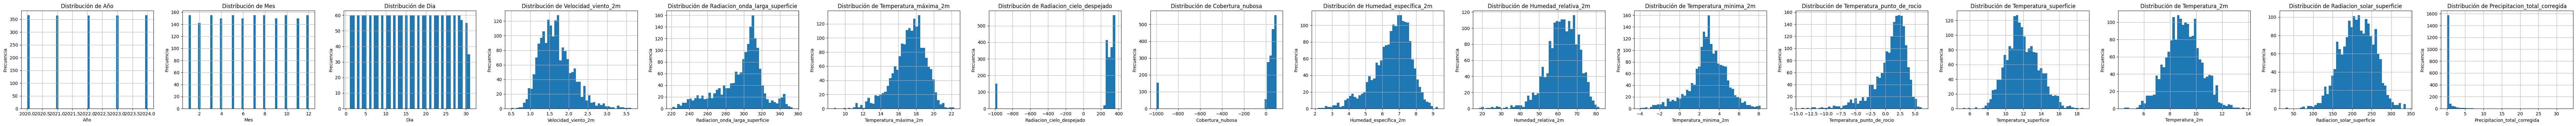

In [173]:

num_cols = df_clima_filtrado.select_dtypes(include='number').columns
n = len(num_cols)

# Crear figura con n subplots en una fila
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(5 * n, 4))

# Generar cada histograma en su respectivo eje
for ax, col in zip(axes, num_cols):
    df_clima_filtrado[col].hist(bins=50, ax=ax)
    ax.set_title(f'Distribución de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')

fig.tight_layout()
plt.show()


### analisis de outliers

In [174]:

# 1. Seleccionar columnas numéricas
num_cols = df_clima_filtrado.select_dtypes(include=np.number).columns

# 2. Calcular Q1, Q3 e IQR
Q1  = df_clima_filtrado[num_cols].quantile(0.25)
Q3  = df_clima_filtrado[num_cols].quantile(0.75)
IQR = Q3 - Q1

# 3. Definir límites inferior y superior
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 4. Detectar outliers: DataFrame booleano
outliers_bool = (df_clima_filtrado[num_cols] < lower) | (df_clima_filtrado[num_cols] > upper)

# 5. Contar outliers por columna
outliers_count = outliers_bool.sum()
print("Outliers por columna:\n", outliers_count)


Outliers por columna:
 Año                                  0
Mes                                  0
Dia                                  0
Velocidad_viento_2m                 40
Radiacion_onda_larga_superficie     62
Temperatura_máxima_2m               49
Radiacion_cielo_despejado          151
Cobertura_nubosa                   154
Humedad_específica_2m               43
Humedad_relativa_2m                 34
Temperatura_minima_2m               91
Temperatura_punto_de_rocio          91
Temperatura_superficie              15
Temperatura_2m                      11
Radiacion_solar_superficie           8
Precipitacion_total_corregida      366
dtype: int64


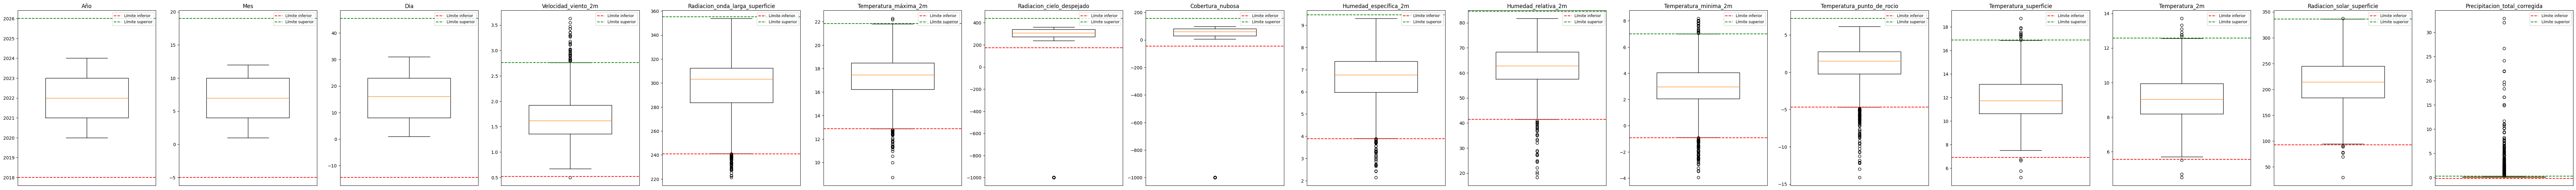

In [175]:
n = len(num_cols)
fig, axes = plt.subplots(
    nrows=1,
    ncols=n,
    figsize=(5 * n, 6),
    sharey=False
)
for ax, col in zip(axes, num_cols):
    # Boxplot
    ax.boxplot(df_clima_filtrado[col].dropna(), vert=True, widths=0.6)

    # Líneas de umbral
    ax.axhline(lower[col], color='red', linestyle='--', label='Límite inferior')
    ax.axhline(upper[col], color='green', linestyle='--', label='Límite superior')

    ax.set_title(col, fontsize=12)
    ax.set_ylabel(None)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.legend(loc='upper right', fontsize='small')

fig.tight_layout()
plt.show()

In [176]:
monthly = df_clima_filtrado.resample('ME').agg({
    'Velocidad_viento_2m': 'mean',
    'Radiacion_onda_larga_superficie': 'mean',
    'Temperatura_máxima_2m': 'max',
    'Radiacion_cielo_despejado': 'mean',
    'Cobertura_nubosa': 'mean',
    'Humedad_específica_2m': 'mean',
    'Humedad_relativa_2m': 'mean',
    'Temperatura_minima_2m': 'min',
    'Temperatura_punto_de_rocio': 'mean',
    'Temperatura_superficie': 'mean',
    'Temperatura_2m': 'mean',
    'Radiacion_solar_superficie': 'mean',
    'Precipitacion_total_corregida': 'sum'
})

In [177]:
# 4. Restaurar Año y Mes como columnas
df_clima_monthly = monthly.reset_index()
df_clima_monthly['Año'] = df_clima_monthly['Fecha'].dt.year
df_clima_monthly['Mes'] = df_clima_monthly['Fecha'].dt.month

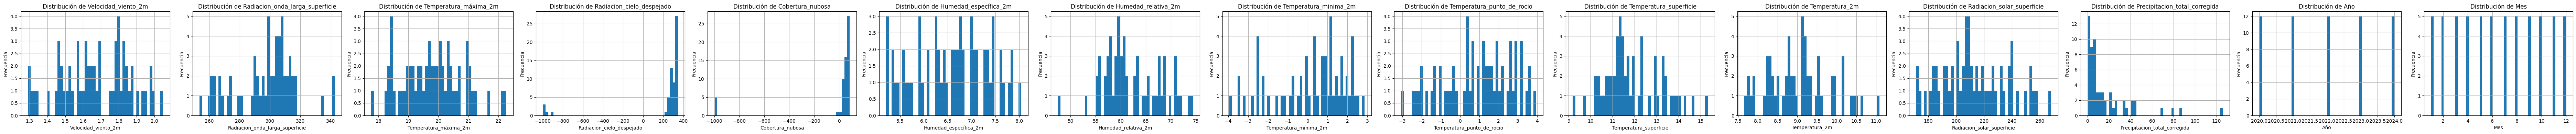

In [178]:

num_cols = df_clima_monthly.select_dtypes(include='number').columns
n = len(num_cols)

# Crear figura con n subplots en una fila
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(5 * n, 4))

# Generar cada histograma en su respectivo eje
for ax, col in zip(axes, num_cols):
    df_clima_monthly[col].hist(bins=50, ax=ax)
    ax.set_title(f'Distribución de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')

fig.tight_layout()
plt.show()


In [179]:

# 1. Seleccionar columnas numéricas
num_cols = df_clima_monthly.select_dtypes(include=np.number).columns

# 2. Calcular Q1, Q3 e IQR
Q1  = df_clima_monthly[num_cols].quantile(0.25)
Q3  = df_clima_monthly[num_cols].quantile(0.75)
IQR = Q3 - Q1

# 3. Definir límites inferior y superior
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 4. Detectar outliers: DataFrame booleano
outliers_bool = (df_clima_monthly[num_cols] < lower) | (df_clima_monthly[num_cols] > upper)

# 5. Contar outliers por columna
outliers_count = outliers_bool.sum()
print("Outliers por columna:\n", outliers_count)


Outliers por columna:
 Velocidad_viento_2m                0
Radiacion_onda_larga_superficie    4
Temperatura_máxima_2m              0
Radiacion_cielo_despejado          5
Cobertura_nubosa                   5
Humedad_específica_2m              0
Humedad_relativa_2m                0
Temperatura_minima_2m              0
Temperatura_punto_de_rocio         0
Temperatura_superficie             0
Temperatura_2m                     0
Radiacion_solar_superficie         0
Precipitacion_total_corregida      4
Año                                0
Mes                                0
dtype: int64


In [180]:
# 6. Calcular la mediana de cada columna numérica
medianas = df_clima_monthly[num_cols].median()

# 7. Reemplazar outliers por la mediana
for col in num_cols:
    df_clima_monthly.loc[outliers_bool[col], col] = medianas[col]

# 8. (Opcional) Verificar que ya no queden outliers
outliers_after = ((df_clima_monthly[num_cols] < lower) | (df_clima_monthly[num_cols] > upper)).sum()
print("Outliers restantes tras reemplazo:\n", outliers_after)

Outliers restantes tras reemplazo:
 Velocidad_viento_2m                0
Radiacion_onda_larga_superficie    0
Temperatura_máxima_2m              0
Radiacion_cielo_despejado          0
Cobertura_nubosa                   0
Humedad_específica_2m              0
Humedad_relativa_2m                0
Temperatura_minima_2m              0
Temperatura_punto_de_rocio         0
Temperatura_superficie             0
Temperatura_2m                     0
Radiacion_solar_superficie         0
Precipitacion_total_corregida      0
Año                                0
Mes                                0
dtype: int64


<ipython-input-180-fd8e89d6c11f>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.5' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_clima_monthly.loc[outliers_bool[col], col] = medianas[col]


In [184]:
df_clima_monthly.head(2)

,Fecha,Velocidad_viento_2m,Radiacion_onda_larga_superficie,Temperatura_máxima_2m,Radiacion_cielo_despejado,Cobertura_nubosa,Humedad_específica_2m,Humedad_relativa_2m,Temperatura_minima_2m,Temperatura_punto_de_rocio,Temperatura_superficie,Temperatura_2m,Radiacion_solar_superficie,Precipitacion_total_corregida,Año,Mes
0,2020-01-31,1.857419,303.485806,18.29,343.502903,68.931935,7.446774,69.674516,0.95,2.863548,11.464516,8.835484,218.728387,34.30,2020,1.0
1,2020-02-29,1.659655,308.881724,18.45,333.255172,78.130345,7.790345,71.056552,2.28,3.512414,11.577241,9.103448,194.387931,44.81,2020,2.0


In [185]:
# 1. Asegúrate de que 'timestamp' sea datetime
df_clima_monthly['Fecha'] = pd.to_datetime(df_clima_monthly['Fecha'])

# 2.a) Suma un MonthEnd para pasar al fin de mes
df_clima_monthly['Fecha'] = df_clima_monthly['Fecha'] + MonthEnd(1)

df_clima_monthly.head()

,Fecha,Velocidad_viento_2m,Radiacion_onda_larga_superficie,Temperatura_máxima_2m,Radiacion_cielo_despejado,Cobertura_nubosa,Humedad_específica_2m,Humedad_relativa_2m,Temperatura_minima_2m,Temperatura_punto_de_rocio,Temperatura_superficie,Temperatura_2m,Radiacion_solar_superficie,Precipitacion_total_corregida,Año,Mes
0,2020-02-29,1.857419,303.485806,18.29,343.502903,68.931935,7.446774,69.674516,0.95,2.863548,11.464516,8.835484,218.728387,34.30,2020,1.0
1,2020-03-31,1.659655,308.881724,18.45,333.255172,78.130345,7.790345,71.056552,2.28,3.512414,11.577241,9.103448,194.387931,44.81,2020,2.0
2,2020-04-30,1.696452,307.702581,19.23,322.302581,77.529032,7.269355,68.169032,-0.90,2.430323,11.360968,8.769032,201.633871,4.75,2020,3.0
3,2020-05-31,1.483000,299.235000,19.16,301.998333,60.728000,7.043333,65.565333,-0.77,1.990667,11.418667,9.125667,212.555000,4.51,2020,4.0
4,2020-06-30,1.571290,291.612258,19.03,274.687419,53.194839,6.584516,61.366452,-2.27,0.997419,11.321935,9.231290,206.600323,1.09,2020,5.0


## Analisis de data camera low cost

In [186]:
df_sensor.head()

,timestamp,latitude,longitude,altitude_m,temperature_C,humidity_%,pressure_hPa,radiation_W/m²,battery_V,memory_used_MB,event_log
0,2020-01-01 00:06:43,-9.383035,-77.526034,4600,0.8,83.7,674.1,102.4,12.35,197.6,OK
1,2020-01-01 00:16:43,-9.382930,-77.525971,4600,-2.8,69.4,696.7,170.2,12.33,173.9,RESTART
2,2020-01-01 00:26:43,-9.383083,-77.525958,4600,2.4,84.2,694.4,355.6,11.50,149.3,SENSOR_FAIL
3,2020-01-01 00:36:43,-9.383036,-77.526051,4600,1.4,80.1,684.9,218.7,12.29,162.3,OK
4,2020-01-01 00:46:43,-9.383033,-77.526092,4600,0.9,87.2,681.4,120.6,12.29,103.7,OK


### renombrado de columnas

In [187]:
df_sensor = df_sensor.rename(columns={
    'temperature_C':   'temperature_c',
    'humidity_%':      'humidity_pct',
    'pressure_hPa':    'pressure_hpa',
    'radiation_W/m²':  'radiation_wm2',
    'battery_V':       'battery_v',
    'memory_used_MB':  'memory_used_mb'
})

In [188]:
missing = df_sensor.isna().sum().to_frame(name='n_missing')
missing['pct_missing'] = 100 * missing['n_missing'] / len(df_sensor)
print("\nValores faltantes por columna:\n", missing)


Valores faltantes por columna:
                 n_missing  pct_missing
timestamp               0          0.0
latitude                0          0.0
longitude               0          0.0
altitude_m              0          0.0
temperature_c           0          0.0
humidity_pct            0          0.0
pressure_hpa            0          0.0
radiation_wm2           0          0.0
battery_v               0          0.0
memory_used_mb          0          0.0
event_log               0          0.0


In [189]:
duplicados_bool = df_sensor.duplicated()
num_duplicados = duplicados_bool.sum()
print(f"\nNúmero de filas duplicadas: {num_duplicados}")


Número de filas duplicadas: 0


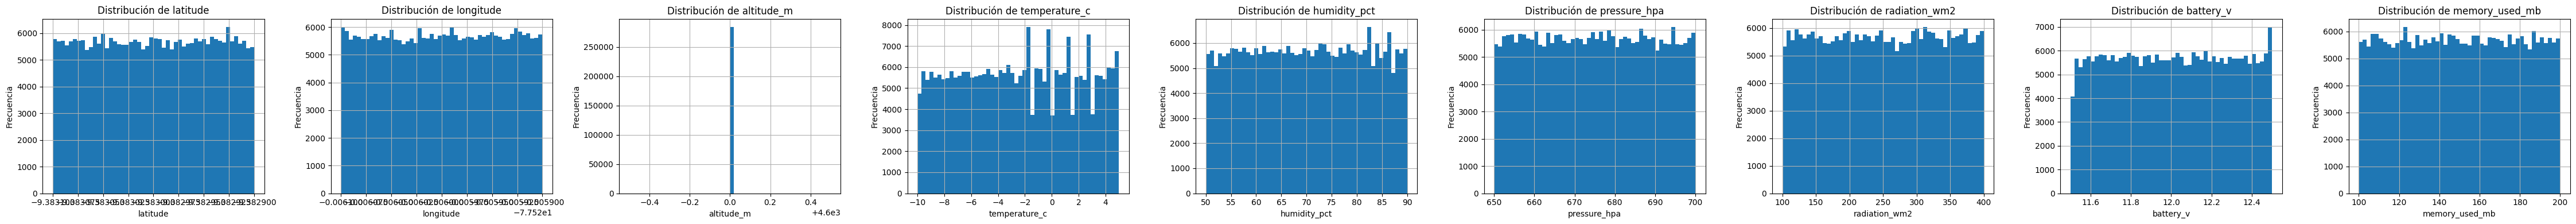

In [190]:

num_cols = df_sensor.select_dtypes(include='number').columns
n = len(num_cols)

# Crear figura con n subplots en una fila
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(5 * n, 4))

# Generar cada histograma en su respectivo eje
for ax, col in zip(axes, num_cols):
    df_sensor[col].hist(bins=50, ax=ax)
    ax.set_title(f'Distribución de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')

fig.tight_layout()
plt.show()


### analisis de outliers

In [191]:

# 1. Seleccionar columnas numéricas
num_cols = df_sensor.select_dtypes(include=np.number).columns

# 2. Calcular Q1, Q3 e IQR
Q1  = df_sensor[num_cols].quantile(0.25)
Q3  = df_sensor[num_cols].quantile(0.75)
IQR = Q3 - Q1

# 3. Definir límites inferior y superior
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 4. Detectar outliers: DataFrame booleano
outliers_bool = (df_sensor[num_cols] < lower) | (df_sensor[num_cols] > upper)

# 5. Contar outliers por columna
outliers_count = outliers_bool.sum()
print("Outliers por columna:\n", outliers_count)


Outliers por columna:
 latitude          0
longitude         0
altitude_m        0
temperature_c     0
humidity_pct      0
pressure_hpa      0
radiation_wm2     0
battery_v         0
memory_used_mb    0
dtype: int64


### Obteniendo registros mensuales

In [192]:
df_sensor['timestamp'] = pd.to_datetime(df_sensor['timestamp'])
df_sensor.set_index('timestamp', inplace=True)

In [193]:
df_sensor_monthly = df_sensor.resample('MS').agg({
    'latitude'       : 'mean',    # posición media
    'longitude'      : 'mean',
    'altitude_m'     : 'mean',    # o 'first' si siempre es igual
    'temperature_c'  : 'mean',    # temperatura promedio mensual
    'humidity_pct'   : 'mean',
    'pressure_hpa'   : 'mean',
    'radiation_wm2'  : 'mean',    # radiación promedio
    'battery_v'      : 'mean',
    'memory_used_mb' : 'mean',
    'event_log'      : lambda x: x.mode()[0]  # evento más frecuente del mes
})

df_sensor_monthly = df_sensor_monthly.reset_index()
df_sensor_monthly['Año'] = df_sensor_monthly['timestamp'].dt.year
df_sensor_monthly['Mes'] = df_sensor_monthly['timestamp'].dt.month

df_sensor_monthly.head()

,timestamp,latitude,longitude,altitude_m,temperature_c,humidity_pct,pressure_hpa,radiation_wm2,battery_v,memory_used_mb,event_log,Año,Mes
0,2020-01-01,-9.382998,-77.526000,4600.0,-2.485372,69.898006,674.669534,251.311514,11.999299,150.018728,SENSOR_FAIL,2020,1
1,2020-02-01,-9.383001,-77.526000,4600.0,-2.468452,70.013517,674.924430,252.063145,11.998651,150.323834,RESTART,2020,2
2,2020-03-01,-9.383000,-77.526001,4600.0,-2.515905,69.974574,675.033714,249.695453,12.000685,149.545273,OK,2020,3
3,2020-04-01,-9.383000,-77.526001,4600.0,-2.385486,70.365116,674.748843,252.016065,11.997359,149.570093,RESTART,2020,4
4,2020-05-01,-9.382999,-77.526000,4600.0,-2.509521,70.035954,675.204973,249.233378,11.999870,149.442518,SENSOR_FAIL,2020,5


In [194]:

# 1. Seleccionar columnas numéricas
num_cols = df_sensor_monthly.select_dtypes(include=np.number).columns

# 2. Calcular Q1, Q3 e IQR
Q1  = df_sensor_monthly[num_cols].quantile(0.25)
Q3  = df_sensor_monthly[num_cols].quantile(0.75)
IQR = Q3 - Q1

# 3. Definir límites inferior y superior
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 4. Detectar outliers: DataFrame booleano
outliers_bool = (df_sensor_monthly[num_cols] < lower) | (df_sensor_monthly[num_cols] > upper)

# 5. Contar outliers por columna
outliers_count = outliers_bool.sum()
print("Outliers por columna:\n", outliers_count)


Outliers por columna:
 latitude           0
longitude          5
altitude_m         0
temperature_c     11
humidity_pct       6
pressure_hpa       0
radiation_wm2      0
battery_v          5
memory_used_mb     0
Año                0
Mes                0
dtype: int64


In [195]:
# 6. Calcular la mediana de cada columna numérica
medianas = df_sensor_monthly[num_cols].median()

# 7. Reemplazar outliers por la mediana
for col in num_cols:
    df_sensor_monthly.loc[outliers_bool[col], col] = medianas[col]

# 8. (Opcional) Verificar que ya no queden outliers
outliers_after = ((df_sensor_monthly[num_cols] < lower) | (df_sensor_monthly[num_cols] > upper)).sum()
print("Outliers restantes tras reemplazo:\n", outliers_after)

Outliers restantes tras reemplazo:
 latitude          0
longitude         0
altitude_m        0
temperature_c     0
humidity_pct      0
pressure_hpa      0
radiation_wm2     0
battery_v         0
memory_used_mb    0
Año               0
Mes               0
dtype: int64


In [196]:
df_sensor_monthly.head(2)

,timestamp,latitude,longitude,altitude_m,temperature_c,humidity_pct,pressure_hpa,radiation_wm2,battery_v,memory_used_mb,event_log,Año,Mes
0,2020-01-01,-9.382998,-77.526,4600.0,-2.485372,69.898006,674.669534,251.311514,11.999299,150.018728,SENSOR_FAIL,2020,1
1,2020-02-01,-9.383001,-77.526,4600.0,-2.468452,70.013517,674.924430,252.063145,11.998651,150.323834,RESTART,2020,2


In [198]:
# 1. Asegúrate de que 'timestamp' sea datetime
df_sensor_monthly['timestamp'] = pd.to_datetime(df_sensor_monthly['timestamp'])

# 2.a) Suma un MonthEnd para pasar al fin de mes
df_sensor_monthly['timestamp'] = df_sensor_monthly['timestamp'] + MonthEnd(1)

df_sensor_monthly.head()

,timestamp,latitude,longitude,altitude_m,temperature_c,humidity_pct,pressure_hpa,radiation_wm2,battery_v,memory_used_mb,event_log,Año,Mes
0,2020-01-31,-9.382998,-77.526000,4600.0,-2.485372,69.898006,674.669534,251.311514,11.999299,150.018728,SENSOR_FAIL,2020,1
1,2020-02-29,-9.383001,-77.526000,4600.0,-2.468452,70.013517,674.924430,252.063145,11.998651,150.323834,RESTART,2020,2
2,2020-03-31,-9.383000,-77.526001,4600.0,-2.515905,69.974574,675.033714,249.695453,12.000685,149.545273,OK,2020,3
3,2020-04-30,-9.383000,-77.526001,4600.0,-2.491296,70.012576,674.748843,252.016065,11.997359,149.570093,RESTART,2020,4
4,2020-05-31,-9.382999,-77.526000,4600.0,-2.509521,70.035954,675.204973,249.233378,11.999870,149.442518,SENSOR_FAIL,2020,5


## Analisis de monitoreo directo

In [200]:
df_directo = pd.read_csv("monitoreo_directo_dummy.csv")
df_indirecto = pd.read_csv("monitoreo_indirecto_dummy.csv")

In [201]:
# 1) Convierte a datetime con el formato correcto
df_directo['date'] = pd.to_datetime(df_directo['date'], format='%d/%m/%Y')

# 2) (Opcional) Si lo quieres como string en 'YYYY-MM-DD'
df_directo['date'] = df_directo['date'].dt.strftime('%Y-%m-%d')

In [202]:
df_directo.head()

,date,monthly_retreat_m,terminus_position_m
0,2017-01-01,0.599343,999.400657
1,2017-02-01,0.472347,998.928310
2,2017-03-01,0.629538,998.298772
3,2017-04-01,0.804606,997.494166
4,2017-05-01,0.453169,997.040997


In [203]:
df_directo = df_directo.rename(columns={
    'date':                   'fecha',
    'monthly_retreat_m':      'retroceso_mensual_m',
    'terminus_position_m':    'posicion_del_termino_m'
})

In [205]:
df_directo['fecha'] = pd.to_datetime(df_directo['fecha'])

df_directo_filtrado = df_directo.loc[df_directo['fecha'].dt.year >= 2020].copy()

df_directo_filtrado.head()

,fecha,retroceso_mensual_m,posicion_del_termino_m
36,2020-01-01,0.541773,982.630896
37,2020-02-01,0.108066,982.522830
38,2020-03-01,0.234363,982.288467
39,2020-04-01,0.539372,981.749095
40,2020-05-01,0.647693,981.101401


In [206]:
nulos_por_col = df_directo_filtrado.isnull().sum()
print("Nulos por columna:")
print(nulos_por_col)

Nulos por columna:
fecha                     0
retroceso_mensual_m       0
posicion_del_termino_m    0
dtype: int64


In [207]:
duplicados_bool = df_directo_filtrado.duplicated()
num_duplicados = duplicados_bool.sum()
print(f"\nNúmero de filas duplicadas: {num_duplicados}")


Número de filas duplicadas: 0


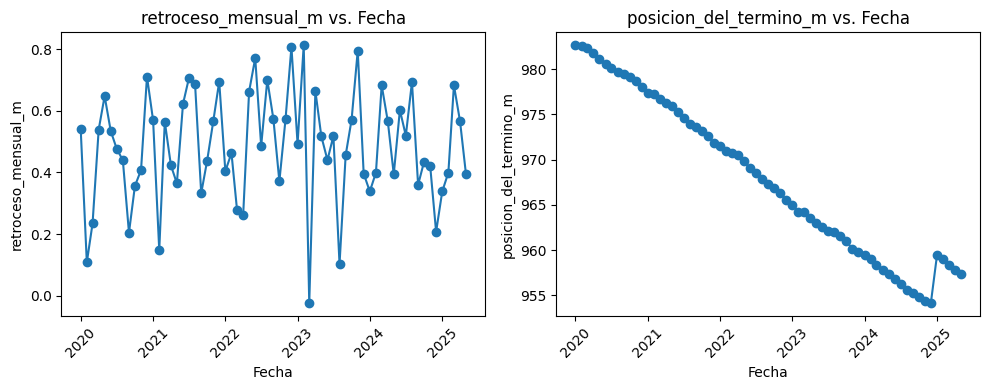

In [208]:

num_cols = df_directo_filtrado.select_dtypes(include='number').columns
n = len(num_cols)

# Crear figura con n subplots en una fila
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(5 * n, 4))

if n == 1:
    axes = [axes]

# Dibuja cada serie temporal
for ax, col in zip(axes, num_cols):
    ax.plot(df_directo_filtrado['fecha'], df_directo_filtrado[col], marker='o', linestyle='-')
    ax.set_title(f'{col} vs. Fecha')
    ax.set_xlabel('Fecha')
    ax.set_ylabel(col)
    ax.tick_params(axis='x', rotation=45)  # gira etiquetas de fecha

fig.tight_layout()
plt.show()


### analisis de outliers

In [209]:

# 1. Seleccionar columnas numéricas
num_cols = df_directo_filtrado.select_dtypes(include=np.number).columns

# 2. Calcular Q1, Q3 e IQR
Q1  = df_directo_filtrado[num_cols].quantile(0.25)
Q3  = df_directo_filtrado[num_cols].quantile(0.75)
IQR = Q3 - Q1

# 3. Definir límites inferior y superior
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 4. Detectar outliers: DataFrame booleano
outliers_bool = (df_directo_filtrado[num_cols] < lower) | (df_directo_filtrado[num_cols] > upper)

# 5. Contar outliers por columna
outliers_count = outliers_bool.sum()
print("Outliers por columna:\n", outliers_count)


Outliers por columna:
 retroceso_mensual_m       1
posicion_del_termino_m    0
dtype: int64


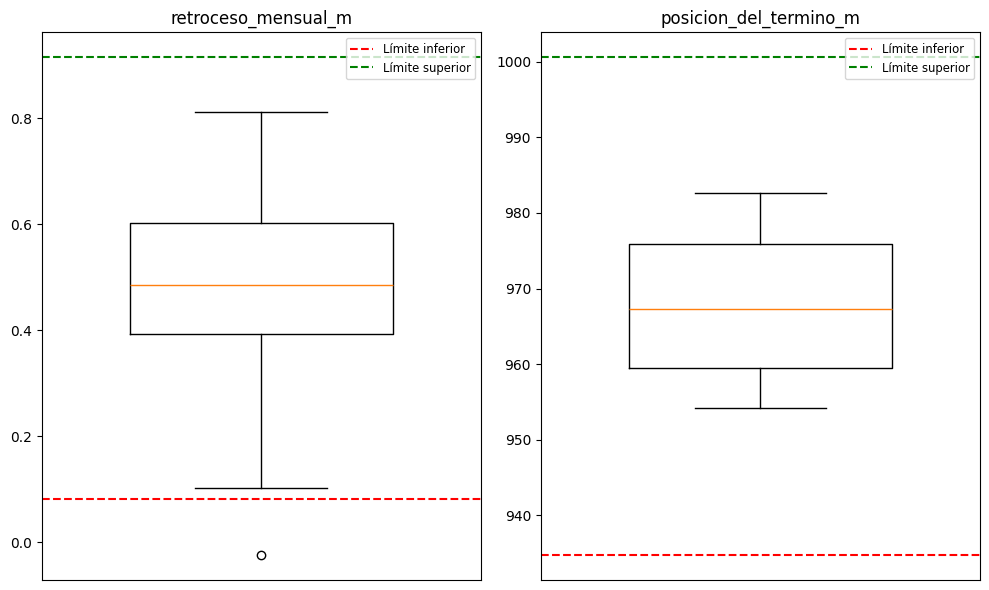

In [210]:
n = len(num_cols)
fig, axes = plt.subplots(
    nrows=1,
    ncols=n,
    figsize=(5 * n, 6),
    sharey=False
)
for ax, col in zip(axes, num_cols):
    # Boxplot
    ax.boxplot(df_directo_filtrado[col].dropna(), vert=True, widths=0.6)

    # Líneas de umbral
    ax.axhline(lower[col], color='red', linestyle='--', label='Límite inferior')
    ax.axhline(upper[col], color='green', linestyle='--', label='Límite superior')

    ax.set_title(col, fontsize=12)
    ax.set_ylabel(None)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.legend(loc='upper right', fontsize='small')

fig.tight_layout()
plt.show()

In [211]:
df_directo_filtrado.head(2)

,fecha,retroceso_mensual_m,posicion_del_termino_m
36,2020-01-01,0.541773,982.630896
37,2020-02-01,0.108066,982.522830


In [212]:
# 1. Asegúrate de que 'timestamp' sea datetime
df_directo_filtrado['fecha'] = pd.to_datetime(df_directo_filtrado['fecha'])

# 2.a) Suma un MonthEnd para pasar al fin de mes
df_directo_filtrado['fecha'] = df_directo_filtrado['fecha'] + MonthEnd(1)

df_directo_filtrado.head()

,fecha,retroceso_mensual_m,posicion_del_termino_m
36,2020-01-31,0.541773,982.630896
37,2020-02-29,0.108066,982.522830
38,2020-03-31,0.234363,982.288467
39,2020-04-30,0.539372,981.749095
40,2020-05-31,0.647693,981.101401


## Analisis de monitorio indirecto

In [213]:
# 1) Convierte a datetime con el formato correcto
df_indirecto['date'] = pd.to_datetime(df_indirecto['date'], format='%d/%m/%Y')

# 2) (Opcional) Si lo quieres como string en 'YYYY-MM-DD'
df_indirecto['date'] = df_indirecto['date'].dt.strftime('%Y-%m-%d')

df_indirecto.head()

,date,ndvi,snow_cover_pct,accumulation_area_ratio,surface_albedo
0,2017-01-01,0.364806,77.051231,0.628099,0.334817
1,2017-02-01,0.472860,58.771306,0.537730,0.316405
2,2017-03-01,0.500256,50.865905,0.579188,0.306835
3,2017-04-01,0.448078,36.926587,0.550700,0.350921
4,2017-05-01,0.279231,19.599951,0.541064,0.369008


In [214]:
df_indirecto = df_indirecto.rename(columns={
    'date'                      : 'fecha',
    'ndvi'                      : 'ndvi',
    'snow_cover_pct'            : 'porcentaje_cobertura_nieve',
    'accumulation_area_ratio'   : 'ratio_area_acumulacion',
    'surface_albedo'            : 'albedo_superficial'
})


In [215]:
df_indirecto['fecha'] = pd.to_datetime(df_indirecto['fecha'])

df_indirecto_filtrado = df_indirecto.loc[df_indirecto['fecha'].dt.year >= 2020].copy()

df_indirecto_filtrado.head()

,fecha,ndvi,porcentaje_cobertura_nieve,ratio_area_acumulacion,albedo_superficial
36,2020-01-01,0.296885,72.404244,0.499398,0.391215
37,2020-02-01,0.483487,68.397989,0.478581,0.348504
38,2020-03-01,0.454029,46.348167,0.715811,0.295021
39,2020-04-01,0.537304,36.082293,0.679166,0.332829
40,2020-05-01,0.310837,24.247097,0.662412,0.362908


In [216]:
nulos_por_col = df_indirecto_filtrado.isnull().sum()
print("Nulos por columna:")
print(nulos_por_col)

Nulos por columna:
fecha                         0
ndvi                          0
porcentaje_cobertura_nieve    0
ratio_area_acumulacion        0
albedo_superficial            0
dtype: int64


In [217]:
duplicados_bool = df_indirecto_filtrado.duplicated()
num_duplicados = duplicados_bool.sum()
print(f"\nNúmero de filas duplicadas: {num_duplicados}")


Número de filas duplicadas: 0


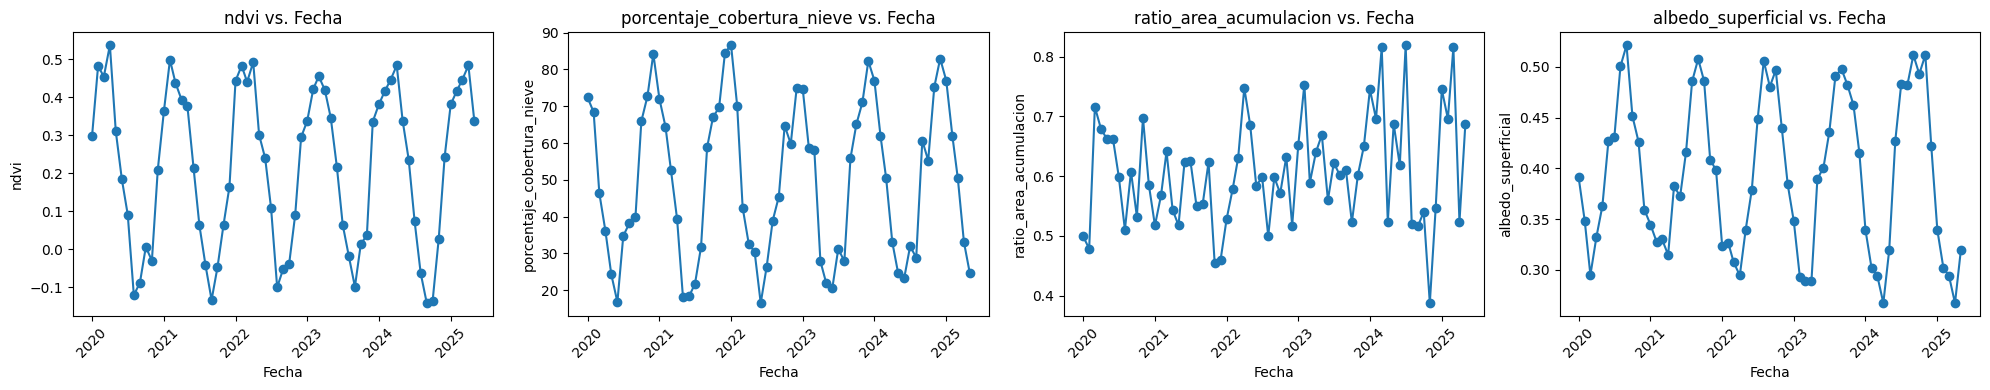

In [218]:
num_cols = df_indirecto_filtrado.select_dtypes(include='number').columns
n = len(num_cols)

# Crear figura con n subplots en una fila
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(5 * n, 4))

if n == 1:
    axes = [axes]

# Dibuja cada serie temporal
for ax, col in zip(axes, num_cols):
    ax.plot(df_indirecto_filtrado['fecha'], df_indirecto_filtrado[col], marker='o', linestyle='-')
    ax.set_title(f'{col} vs. Fecha')
    ax.set_xlabel('Fecha')
    ax.set_ylabel(col)
    ax.tick_params(axis='x', rotation=45)  # gira etiquetas de fecha

fig.tight_layout()
plt.show()


In [219]:

# 1. Seleccionar columnas numéricas
num_cols = df_indirecto_filtrado.select_dtypes(include=np.number).columns

# 2. Calcular Q1, Q3 e IQR
Q1  = df_indirecto_filtrado[num_cols].quantile(0.25)
Q3  = df_indirecto_filtrado[num_cols].quantile(0.75)
IQR = Q3 - Q1

# 3. Definir límites inferior y superior
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 4. Detectar outliers: DataFrame booleano
outliers_bool = (df_indirecto_filtrado[num_cols] < lower) | (df_indirecto_filtrado[num_cols] > upper)

# 5. Contar outliers por columna
outliers_count = outliers_bool.sum()
print("Outliers por columna:\n", outliers_count)


Outliers por columna:
 ndvi                          0
porcentaje_cobertura_nieve    0
ratio_area_acumulacion        0
albedo_superficial            0
dtype: int64


In [220]:
# 1. Asegúrate de que 'timestamp' sea datetime
df_indirecto_filtrado['fecha'] = pd.to_datetime(df_indirecto_filtrado['fecha'])

# 2.a) Suma un MonthEnd para pasar al fin de mes
df_indirecto_filtrado['fecha'] = df_indirecto_filtrado['fecha'] + MonthEnd(1)

df_indirecto_filtrado.head()

,fecha,ndvi,porcentaje_cobertura_nieve,ratio_area_acumulacion,albedo_superficial
36,2020-01-31,0.296885,72.404244,0.499398,0.391215
37,2020-02-29,0.483487,68.397989,0.478581,0.348504
38,2020-03-31,0.454029,46.348167,0.715811,0.295021
39,2020-04-30,0.537304,36.082293,0.679166,0.332829
40,2020-05-31,0.310837,24.247097,0.662412,0.362908


# Consolidado de las fuentes en un solo tablon

In [222]:
df_clima_monthly.head(2)

,Fecha,Velocidad_viento_2m,Radiacion_onda_larga_superficie,Temperatura_máxima_2m,Radiacion_cielo_despejado,Cobertura_nubosa,Humedad_específica_2m,Humedad_relativa_2m,Temperatura_minima_2m,Temperatura_punto_de_rocio,Temperatura_superficie,Temperatura_2m,Radiacion_solar_superficie,Precipitacion_total_corregida,Año,Mes
0,2020-02-29,1.857419,303.485806,18.29,343.502903,68.931935,7.446774,69.674516,0.95,2.863548,11.464516,8.835484,218.728387,34.30,2020,1.0
1,2020-03-31,1.659655,308.881724,18.45,333.255172,78.130345,7.790345,71.056552,2.28,3.512414,11.577241,9.103448,194.387931,44.81,2020,2.0


In [223]:
df_sensor_monthly.head(2)

,timestamp,latitude,longitude,altitude_m,temperature_c,humidity_pct,pressure_hpa,radiation_wm2,battery_v,memory_used_mb,event_log,Año,Mes
0,2020-01-31,-9.382998,-77.526,4600.0,-2.485372,69.898006,674.669534,251.311514,11.999299,150.018728,SENSOR_FAIL,2020,1
1,2020-02-29,-9.383001,-77.526,4600.0,-2.468452,70.013517,674.924430,252.063145,11.998651,150.323834,RESTART,2020,2


In [224]:
df_nasa_sensor = df_clima_monthly.merge(
    df_sensor_monthly,
    left_on='Fecha',
    right_on='timestamp',
    how='inner',  # o 'left'/'right' según lo que necesites
    suffixes=('_clima', '_sensor')
)

df_nasa_sensor.head()

,Fecha,Velocidad_viento_2m,Radiacion_onda_larga_superficie,Temperatura_máxima_2m,Radiacion_cielo_despejado,Cobertura_nubosa,Humedad_específica_2m,Humedad_relativa_2m,Temperatura_minima_2m,Temperatura_punto_de_rocio,...,altitude_m,temperature_c,humidity_pct,pressure_hpa,radiation_wm2,battery_v,memory_used_mb,event_log,Año_sensor,Mes_sensor
0,2020-02-29,1.857419,303.485806,18.29,343.502903,68.931935,7.446774,69.674516,0.95,2.863548,...,4600.0,-2.468452,70.013517,674.924430,252.063145,11.998651,150.323834,RESTART,2020,2
1,2020-03-31,1.659655,308.881724,18.45,333.255172,78.130345,7.790345,71.056552,2.28,3.512414,...,4600.0,-2.515905,69.974574,675.033714,249.695453,12.000685,149.545273,OK,2020,3
2,2020-04-30,1.696452,307.702581,19.23,322.302581,77.529032,7.269355,68.169032,-0.90,2.430323,...,4600.0,-2.491296,70.012576,674.748843,252.016065,11.997359,149.570093,RESTART,2020,4
3,2020-05-31,1.483000,299.235000,19.16,301.998333,60.728000,7.043333,65.565333,-0.77,1.990667,...,4600.0,-2.509521,70.035954,675.204973,249.233378,11.999870,149.442518,SENSOR_FAIL,2020,5
4,2020-06-30,1.571290,291.612258,19.03,274.687419,53.194839,6.584516,61.366452,-2.27,0.997419,...,4600.0,-2.516852,70.065532,674.766088,249.188079,12.002924,149.675532,RESTART,2020,6


In [226]:
df_directo_filtrado

,fecha,retroceso_mensual_m,posicion_del_termino_m
36,2020-01-31,0.541773,982.630896
37,2020-02-29,0.108066,982.522830
38,2020-03-31,0.234363,982.288467
39,2020-04-30,0.539372,981.749095
40,2020-05-31,0.647693,981.101401
...,...,...,...
96,2025-01-31,0.338301,959.423728
97,2025-02-28,0.399649,959.024080
98,2025-03-31,0.683080,958.340999
99,2025-04-30,0.565750,957.775249


In [228]:
df_nasa_sensor_dir = df_nasa_sensor.merge(
    df_directo_filtrado,
    left_on='Fecha',
    right_on='fecha',
    how='inner',  # o 'left'/'right' según lo que necesites
    suffixes=('_clima', '_sensor')
)

df_nasa_sensor_dir.head()

,Fecha,Velocidad_viento_2m,Radiacion_onda_larga_superficie,Temperatura_máxima_2m,Radiacion_cielo_despejado,Cobertura_nubosa,Humedad_específica_2m,Humedad_relativa_2m,Temperatura_minima_2m,Temperatura_punto_de_rocio,...,pressure_hpa,radiation_wm2,battery_v,memory_used_mb,event_log,Año_sensor,Mes_sensor,fecha,retroceso_mensual_m,posicion_del_termino_m
0,2020-02-29,1.857419,303.485806,18.29,343.502903,68.931935,7.446774,69.674516,0.95,2.863548,...,674.924430,252.063145,11.998651,150.323834,RESTART,2020,2,2020-02-29,0.108066,982.522830
1,2020-03-31,1.659655,308.881724,18.45,333.255172,78.130345,7.790345,71.056552,2.28,3.512414,...,675.033714,249.695453,12.000685,149.545273,OK,2020,3,2020-03-31,0.234363,982.288467
2,2020-04-30,1.696452,307.702581,19.23,322.302581,77.529032,7.269355,68.169032,-0.90,2.430323,...,674.748843,252.016065,11.997359,149.570093,RESTART,2020,4,2020-04-30,0.539372,981.749095
3,2020-05-31,1.483000,299.235000,19.16,301.998333,60.728000,7.043333,65.565333,-0.77,1.990667,...,675.204973,249.233378,11.999870,149.442518,SENSOR_FAIL,2020,5,2020-05-31,0.647693,981.101401
4,2020-06-30,1.571290,291.612258,19.03,274.687419,53.194839,6.584516,61.366452,-2.27,0.997419,...,674.766088,249.188079,12.002924,149.675532,RESTART,2020,6,2020-06-30,0.534274,980.567128


In [230]:
df_nasa_sensor_dir_indir = df_nasa_sensor_dir.merge(
    df_indirecto_filtrado,
    left_on='Fecha',
    right_on='fecha',
    how='inner',  # o 'left'/'right' según lo que necesites
    suffixes=('_clima', '_sensor')
)

df_nasa_sensor_dir_indir.head()

,Fecha,Velocidad_viento_2m,Radiacion_onda_larga_superficie,Temperatura_máxima_2m,Radiacion_cielo_despejado,Cobertura_nubosa,Humedad_específica_2m,Humedad_relativa_2m,Temperatura_minima_2m,Temperatura_punto_de_rocio,...,Año_sensor,Mes_sensor,fecha_clima,retroceso_mensual_m,posicion_del_termino_m,fecha_sensor,ndvi,porcentaje_cobertura_nieve,ratio_area_acumulacion,albedo_superficial
0,2020-02-29,1.857419,303.485806,18.29,343.502903,68.931935,7.446774,69.674516,0.95,2.863548,...,2020,2,2020-02-29,0.108066,982.522830,2020-02-29,0.483487,68.397989,0.478581,0.348504
1,2020-03-31,1.659655,308.881724,18.45,333.255172,78.130345,7.790345,71.056552,2.28,3.512414,...,2020,3,2020-03-31,0.234363,982.288467,2020-03-31,0.454029,46.348167,0.715811,0.295021
2,2020-04-30,1.696452,307.702581,19.23,322.302581,77.529032,7.269355,68.169032,-0.90,2.430323,...,2020,4,2020-04-30,0.539372,981.749095,2020-04-30,0.537304,36.082293,0.679166,0.332829
3,2020-05-31,1.483000,299.235000,19.16,301.998333,60.728000,7.043333,65.565333,-0.77,1.990667,...,2020,5,2020-05-31,0.647693,981.101401,2020-05-31,0.310837,24.247097,0.662412,0.362908
4,2020-06-30,1.571290,291.612258,19.03,274.687419,53.194839,6.584516,61.366452,-2.27,0.997419,...,2020,6,2020-06-30,0.534274,980.567128,2020-06-30,0.183897,16.741998,0.662835,0.427373


In [234]:
df_nasa_sensor_dir_indir.columns

Index(['Fecha', 'Velocidad_viento_2m', 'Radiacion_onda_larga_superficie',
       'Temperatura_máxima_2m', 'Radiacion_cielo_despejado',
       'Cobertura_nubosa', 'Humedad_específica_2m', 'Humedad_relativa_2m',
       'Temperatura_minima_2m', 'Temperatura_punto_de_rocio',
       'Temperatura_superficie', 'Temperatura_2m',
       'Radiacion_solar_superficie', 'Precipitacion_total_corregida',
       'Año_clima', 'Mes_clima', 'timestamp', 'latitude', 'longitude',
       'altitude_m', 'temperature_c', 'humidity_pct', 'pressure_hpa',
       'radiation_wm2', 'battery_v', 'memory_used_mb', 'event_log',
       'Año_sensor', 'Mes_sensor', 'fecha_clima', 'retroceso_mensual_m',
       'posicion_del_termino_m', 'fecha_sensor', 'ndvi',
       'porcentaje_cobertura_nieve', 'ratio_area_acumulacion',
       'albedo_superficial'],
      dtype='object')

In [235]:
df_nasa_sensor_dir_indir.to_excel('df_monitoreo_llaca.xlsx', index=False)

# Anlasis del tablon de monitoreo glaciar

In [255]:
df = pd.read_excel('df_monitoreo_llaca.xlsx', parse_dates=['Fecha'])
# Filtrar valores nulos en objetivo
df_monitoreo_glaciar = df.dropna(subset=['retroceso_mensual_m']).copy()

In [256]:
df_monitoreo_glaciar['Fecha'] = pd.to_datetime(df_monitoreo_glaciar['Fecha'])

In [257]:
df_monitoreo_glaciar.head()

,Fecha,Velocidad_viento_2m,Radiacion_onda_larga_superficie,Temperatura_máxima_2m,Radiacion_cielo_despejado,Cobertura_nubosa,Humedad_específica_2m,Humedad_relativa_2m,Temperatura_minima_2m,Temperatura_punto_de_rocio,...,Año_sensor,Mes_sensor,fecha_clima,retroceso_mensual_m,posicion_del_termino_m,fecha_sensor,ndvi,porcentaje_cobertura_nieve,ratio_area_acumulacion,albedo_superficial
0,2020-02-29,1.857419,303.485806,18.29,343.502903,68.931935,7.446774,69.674516,0.95,2.863548,...,2020,2,2020-02-29,0.108066,982.522830,2020-02-29,0.483487,68.397989,0.478581,0.348504
1,2020-03-31,1.659655,308.881724,18.45,333.255172,78.130345,7.790345,71.056552,2.28,3.512414,...,2020,3,2020-03-31,0.234363,982.288467,2020-03-31,0.454029,46.348167,0.715811,0.295021
2,2020-04-30,1.696452,307.702581,19.23,322.302581,77.529032,7.269355,68.169032,-0.90,2.430323,...,2020,4,2020-04-30,0.539372,981.749095,2020-04-30,0.537304,36.082293,0.679166,0.332829
3,2020-05-31,1.483000,299.235000,19.16,301.998333,60.728000,7.043333,65.565333,-0.77,1.990667,...,2020,5,2020-05-31,0.647693,981.101401,2020-05-31,0.310837,24.247097,0.662412,0.362908
4,2020-06-30,1.571290,291.612258,19.03,274.687419,53.194839,6.584516,61.366452,-2.27,0.997419,...,2020,6,2020-06-30,0.534274,980.567128,2020-06-30,0.183897,16.741998,0.662835,0.427373


In [258]:
df_monitoreo_glaciar.columns

Index(['Fecha', 'Velocidad_viento_2m', 'Radiacion_onda_larga_superficie',
       'Temperatura_máxima_2m', 'Radiacion_cielo_despejado',
       'Cobertura_nubosa', 'Humedad_específica_2m', 'Humedad_relativa_2m',
       'Temperatura_minima_2m', 'Temperatura_punto_de_rocio',
       'Temperatura_superficie', 'Temperatura_2m',
       'Radiacion_solar_superficie', 'Precipitacion_total_corregida',
       'Año_clima', 'Mes_clima', 'timestamp', 'latitude', 'longitude',
       'altitude_m', 'temperature_c', 'humidity_pct', 'pressure_hpa',
       'radiation_wm2', 'battery_v', 'memory_used_mb', 'event_log',
       'Año_sensor', 'Mes_sensor', 'fecha_clima', 'retroceso_mensual_m',
       'posicion_del_termino_m', 'fecha_sensor', 'ndvi',
       'porcentaje_cobertura_nieve', 'ratio_area_acumulacion',
       'albedo_superficial'],
      dtype='object')

In [259]:
cols_to_remove = [
    'fecha_sensor', 'fecha_clima', 'Mes_sensor', 'Año_sensor',
    'battery_v', 'memory_used_mb', 'timestamp', 'Mes_clima', 'Año_clima'
]
df_monitoreo_glaciar = df_monitoreo_glaciar.drop(columns=cols_to_remove, errors='ignore')

df_monitoreo_glaciar.head(4)

,Fecha,Velocidad_viento_2m,Radiacion_onda_larga_superficie,Temperatura_máxima_2m,Radiacion_cielo_despejado,Cobertura_nubosa,Humedad_específica_2m,Humedad_relativa_2m,Temperatura_minima_2m,Temperatura_punto_de_rocio,...,humidity_pct,pressure_hpa,radiation_wm2,event_log,retroceso_mensual_m,posicion_del_termino_m,ndvi,porcentaje_cobertura_nieve,ratio_area_acumulacion,albedo_superficial
0,2020-02-29,1.857419,303.485806,18.29,343.502903,68.931935,7.446774,69.674516,0.95,2.863548,...,70.013517,674.924430,252.063145,RESTART,0.108066,982.522830,0.483487,68.397989,0.478581,0.348504
1,2020-03-31,1.659655,308.881724,18.45,333.255172,78.130345,7.790345,71.056552,2.28,3.512414,...,69.974574,675.033714,249.695453,OK,0.234363,982.288467,0.454029,46.348167,0.715811,0.295021
2,2020-04-30,1.696452,307.702581,19.23,322.302581,77.529032,7.269355,68.169032,-0.90,2.430323,...,70.012576,674.748843,252.016065,RESTART,0.539372,981.749095,0.537304,36.082293,0.679166,0.332829
3,2020-05-31,1.483000,299.235000,19.16,301.998333,60.728000,7.043333,65.565333,-0.77,1.990667,...,70.035954,675.204973,249.233378,SENSOR_FAIL,0.647693,981.101401,0.310837,24.247097,0.662412,0.362908


## analisis de estacionalidad

In [262]:
df_monitoreo_glaciar['Fecha'] = pd.to_datetime(df_monitoreo_glaciar['Fecha'])
df_monitoreo_glaciar['year']  = df_monitoreo_glaciar['Fecha'].dt.year
df_monitoreo_glaciar['month'] = df_monitoreo_glaciar['Fecha'].dt.month

In [263]:
# Agrupar por año y mes y calcular el promedio de retroceso
monthly = (
    df_monitoreo_glaciar
    .groupby(['year', 'month'], as_index=False)
    .agg({'retroceso_mensual_m': 'mean'})
)

In [264]:
# Construir la tabla pivote
pivot_retroceso = monthly.pivot(
    index='year',
    columns='month',
    values='retroceso_mensual_m'
)

print("Promedio mensual de retroceso por año:")
print(pivot_retroceso)

Promedio mensual de retroceso por año:
month        1         2         3         4         5         6         7   \
year                                                                          
2020        NaN  0.108066  0.234363  0.539372  0.647693  0.534274  0.476870   
2021   0.568724  0.147392  0.564817  0.422984  0.364616  0.622335  0.706200   
2022   0.404165  0.462868  0.278733  0.260759  0.662505  0.771248  0.485598   
2023   0.492835  0.812929 -0.023949  0.664381  0.517409  0.440199  0.518352   
2024   0.338301  0.399649  0.683080  0.565750  0.394048  0.602653  0.519416   
2025   0.338301       NaN       NaN       NaN       NaN       NaN       NaN   

month        8         9         10        11        12  
year                                                     
2020   0.439779  0.204296  0.356031  0.407872  0.711424  
2021   0.686256  0.332156  0.438158  0.566253  0.695109  
2022   0.700707  0.572327  0.370976  0.572279  0.807607  
2023   0.102486  0.456066  0.571423  0

## Serie temporal mensual de retroceso

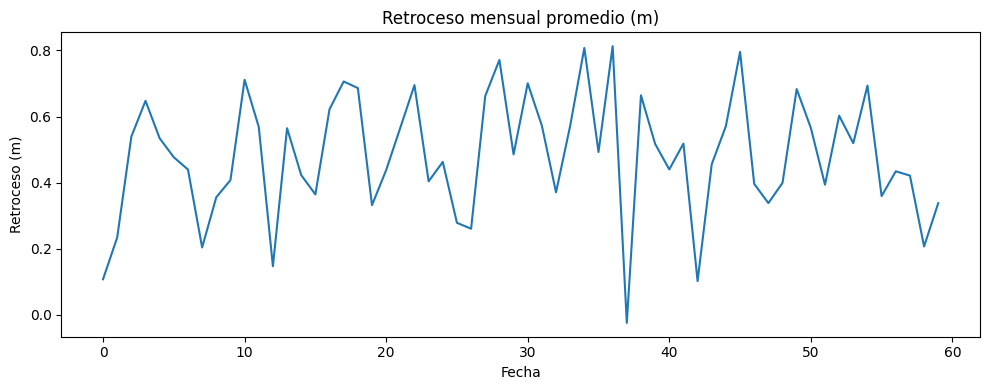

In [265]:
plt.figure(figsize=(10, 4))
monthly['retroceso_mensual_m'].plot(title='Retroceso mensual promedio (m)')
plt.xlabel('Fecha')
plt.ylabel('Retroceso (m)')
plt.tight_layout()
plt.show()

## Analisis de correlacion

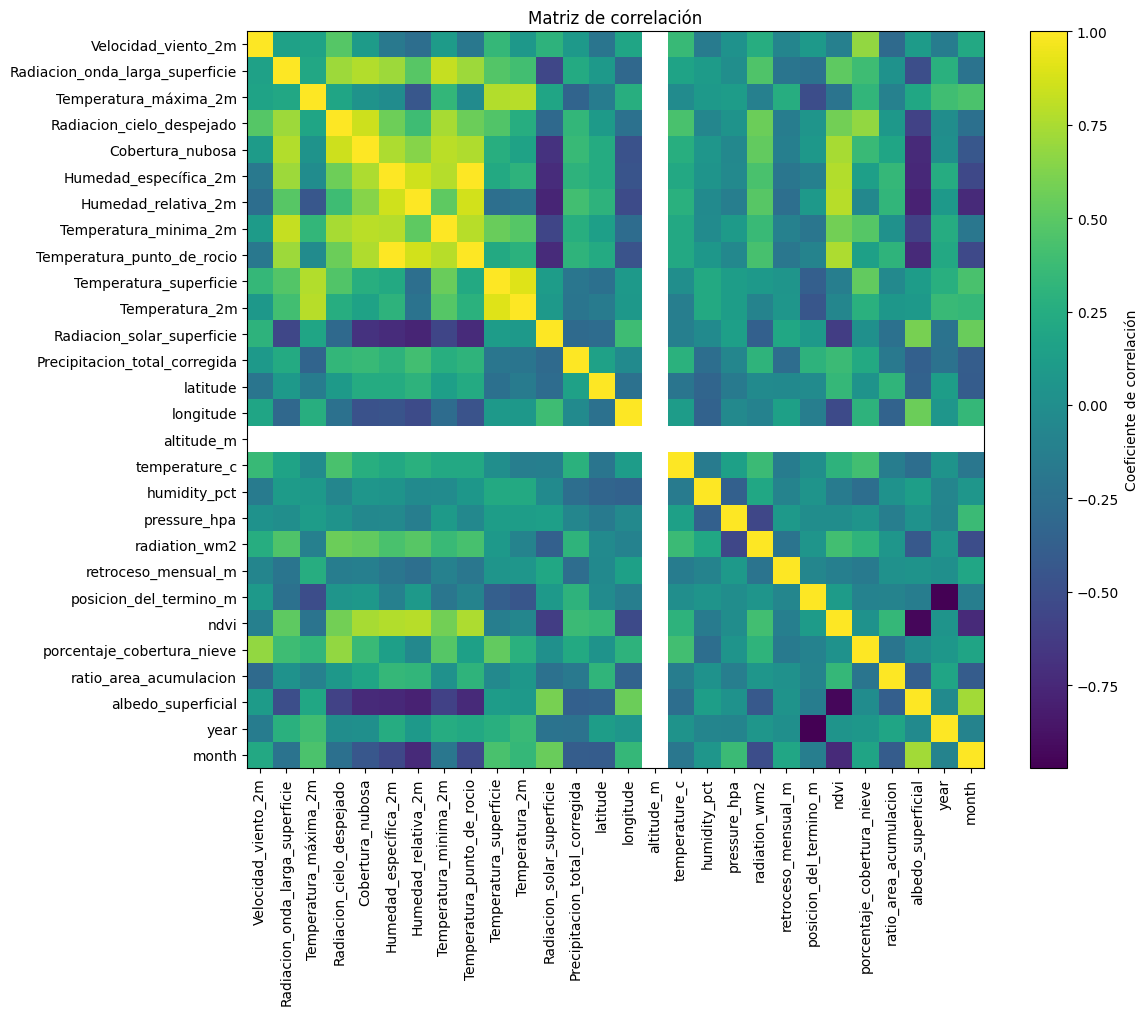

In [266]:
corr = df_monitoreo_glaciar.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
plt.imshow(corr, aspect='equal')
plt.title('Matriz de correlación')
plt.colorbar(label='Coeficiente de correlación')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.tight_layout()
plt.show()

## seleccion de variables

In [267]:
upper = corr.where(~np.tril(np.ones(corr.shape), k=0).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col].abs() > 0.9)]
print("Variables eliminadas por alta correlación:", to_drop)
df_reduced = df_monitoreo_glaciar.drop(columns=to_drop)

Variables eliminadas por alta correlación: ['Temperatura_punto_de_rocio', 'Temperatura_2m', 'albedo_superficial', 'year']


## featuring engeneering

In [272]:
df_fe = df_reduced.copy()

df_fe['Fecha'] = pd.to_datetime(df_fe['Fecha'])

df_fe = df_fe.sort_values('Fecha')

df_fe['mes']  = df_fe['Fecha'].dt.month
df_fe['anio'] = df_fe['Fecha'].dt.year

df_fe['rolling_mean_3'] = df_fe['retroceso_mensual_m'].rolling(window=3).mean()

print(df_fe[['Fecha','mes','anio','retroceso_mensual_m','rolling_mean_3']].head(10))

       Fecha  mes  anio  retroceso_mensual_m  rolling_mean_3
0 2020-02-29    2  2020             0.108066             NaN
1 2020-03-31    3  2020             0.234363             NaN
2 2020-04-30    4  2020             0.539372        0.293934
3 2020-05-31    5  2020             0.647693        0.473809
4 2020-06-30    6  2020             0.534274        0.573780
5 2020-07-31    7  2020             0.476870        0.552946
6 2020-08-31    8  2020             0.439779        0.483641
7 2020-09-30    9  2020             0.204296        0.373648
8 2020-10-31   10  2020             0.356031        0.333369
9 2020-11-30   11  2020             0.407872        0.322733


In [276]:
df_fe = df_fe.rename(columns={
    'rolling_mean_3': 'media_movil_3_meses'
})

df_fe.columns

Index(['Fecha', 'Velocidad_viento_2m', 'Radiacion_onda_larga_superficie',
       'Temperatura_máxima_2m', 'Radiacion_cielo_despejado',
       'Cobertura_nubosa', 'Humedad_específica_2m', 'Humedad_relativa_2m',
       'Temperatura_minima_2m', 'Temperatura_superficie',
       'Radiacion_solar_superficie', 'Precipitacion_total_corregida',
       'latitude', 'longitude', 'altitude_m', 'temperature_c', 'humidity_pct',
       'pressure_hpa', 'radiation_wm2', 'event_log', 'retroceso_mensual_m',
       'posicion_del_termino_m', 'ndvi', 'porcentaje_cobertura_nieve',
       'ratio_area_acumulacion', 'month', 'mes', 'anio',
       'media_movil_3_meses'],
      dtype='object')

In [277]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Fecha                            60 non-null     datetime64[ns]
 1   Velocidad_viento_2m              60 non-null     float64       
 2   Radiacion_onda_larga_superficie  60 non-null     float64       
 3   Temperatura_máxima_2m            60 non-null     float64       
 4   Radiacion_cielo_despejado        60 non-null     float64       
 5   Cobertura_nubosa                 60 non-null     float64       
 6   Humedad_específica_2m            60 non-null     float64       
 7   Humedad_relativa_2m              60 non-null     float64       
 8   Temperatura_minima_2m            60 non-null     float64       
 9   Temperatura_superficie           60 non-null     float64       
 10  Radiacion_solar_superficie       60 non-null     float64       


# desarrollo del modelo de prediccion

## calcular el target

In [281]:

# 1. Extraer año para agrupar
df_fe['year'] = df_fe['Fecha'].dt.year

# 2. Filtrar años con al menos 2 observaciones
counts = df_fe.groupby('year')['posicion_del_termino_m'].count()
valid_years = counts[counts >= 2].index
df_fe = df_fe[df_fe['year'].isin(valid_years)].copy()

# 3. Calcular P_ini y P_fin por año
df_anual = df_fe.groupby('year').agg(
    P_ini=('posicion_del_termino_m', 'first'),
    P_fin=('posicion_del_termino_m', 'last'),
)

# 4. Definir el target anual (positivo)
df_anual['tasa_retroceso_anual_m'] = df_anual['P_ini'] - df_anual['P_fin']

# 5. Unir el target anual de vuelta a df_fe
df_fe = df_fe.merge(
    df_anual[['tasa_retroceso_anual_m']],
    left_on='year', right_index=True
)

# 6. Verificar que cada fila mensual tenga su target
print(df_fe[['Fecha','year','posicion_del_termino_m','tasa_retroceso_anual_m']].head(12))


        Fecha  year  posicion_del_termino_m  tasa_retroceso_anual_m
0  2020-02-29  2020              982.522830                4.551975
1  2020-03-31  2020              982.288467                4.551975
2  2020-04-30  2020              981.749095                4.551975
3  2020-05-31  2020              981.101401                4.551975
4  2020-06-30  2020              980.567128                4.551975
5  2020-07-31  2020              980.090257                4.551975
6  2020-08-31  2020              979.650478                4.551975
7  2020-09-30  2020              979.446182                4.551975
8  2020-10-31  2020              979.090151                4.551975
9  2020-11-30  2020              978.682279                4.551975
10 2020-12-31  2020              977.970855                4.551975
11 2021-01-31  2021              977.402131                5.546275


In [282]:
df_fe.columns

Index(['Fecha', 'Velocidad_viento_2m', 'Radiacion_onda_larga_superficie',
       'Temperatura_máxima_2m', 'Radiacion_cielo_despejado',
       'Cobertura_nubosa', 'Humedad_específica_2m', 'Humedad_relativa_2m',
       'Temperatura_minima_2m', 'Temperatura_superficie',
       'Radiacion_solar_superficie', 'Precipitacion_total_corregida',
       'latitude', 'longitude', 'altitude_m', 'temperature_c', 'humidity_pct',
       'pressure_hpa', 'radiation_wm2', 'event_log', 'retroceso_mensual_m',
       'posicion_del_termino_m', 'ndvi', 'porcentaje_cobertura_nieve',
       'ratio_area_acumulacion', 'month', 'mes', 'anio', 'media_movil_3_meses',
       'year', 'tasa_retroceso_anual_m'],
      dtype='object')

In [300]:
df_fe = df_fe.drop(columns=['event_log', 'Fecha'])

In [306]:
nan_cols = df_fe.columns[df_fe.isnull().any()]
print("Columnas con valores NaN:", nan_cols.tolist())

Columnas con valores NaN: ['media_movil_3_meses']


In [ ]:
for col in nan_cols:
    mean_val = df_fe[col].mean()
    df_fe[col].fillna(mean_val, inplace=True)

# Verificar que ya no haya NaN
print("NaN restantes por columna:\n", df_fe.isnull().sum())

## particion

In [309]:
X = df_fe.drop(columns=['tasa_retroceso_anual_m'])
y = df_fe['tasa_retroceso_anual_m']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## modelo y entrenamiento

In [310]:
models = {
    'Regresión Lineal'      : LinearRegression(),
    'Random Forest'         : RandomForestRegressor(random_state=42),
    'Gradient Boosting'     : GradientBoostingRegressor(random_state=42),
    'Soporte Vectorial (SVR)': SVR()
}

In [311]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Modelo'       : name,
        'MAE'           : mean_absolute_error(y_test, y_pred),
        'RMSE'          : np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²'            : r2_score(y_test, y_pred)
    })

In [314]:
results_df = pd.DataFrame(results).set_index('Modelo')
# Elegimos el modelo con mayor R²
best_model_name = results_df['R²'].idxmax()
best_model = models[best_model_name]

print(f"Mejor modelo según R²: {best_model_name}")
print(results_df)

Mejor modelo según R²: Gradient Boosting
                              MAE      RMSE        R²
Modelo                                               
Regresión Lineal         0.167184  0.211102  0.795021
Random Forest            0.024536  0.054608  0.986284
Gradient Boosting        0.011255  0.035103  0.994332
Soporte Vectorial (SVR)  0.373007  0.484052 -0.077723


### probando el modelo con df

In [316]:
df_test_predict = df_fe.drop(columns=['tasa_retroceso_anual_m'])
df_test_predict.columns

Index(['Velocidad_viento_2m', 'Radiacion_onda_larga_superficie',
       'Temperatura_máxima_2m', 'Radiacion_cielo_despejado',
       'Cobertura_nubosa', 'Humedad_específica_2m', 'Humedad_relativa_2m',
       'Temperatura_minima_2m', 'Temperatura_superficie',
       'Radiacion_solar_superficie', 'Precipitacion_total_corregida',
       'latitude', 'longitude', 'altitude_m', 'temperature_c', 'humidity_pct',
       'pressure_hpa', 'radiation_wm2', 'retroceso_mensual_m',
       'posicion_del_termino_m', 'ndvi', 'porcentaje_cobertura_nieve',
       'ratio_area_acumulacion', 'month', 'mes', 'anio', 'media_movil_3_meses',
       'year'],
      dtype='object')

In [317]:
nan_cols = df_test_predict.columns[df_test_predict.isnull().any()]
for col in nan_cols:
    df_test_predict[col].fillna(df_test_predict[col].mean(), inplace=True)

In [318]:
df_predicho = df_test_predict.copy()
df_predicho['prediccion_tasa_retroceso_glaciar'] = best_model.predict(df_test_predict)

In [319]:
df_predicho.head()

,Velocidad_viento_2m,Radiacion_onda_larga_superficie,Temperatura_máxima_2m,Radiacion_cielo_despejado,Cobertura_nubosa,Humedad_específica_2m,Humedad_relativa_2m,Temperatura_minima_2m,Temperatura_superficie,Radiacion_solar_superficie,...,posicion_del_termino_m,ndvi,porcentaje_cobertura_nieve,ratio_area_acumulacion,month,mes,anio,media_movil_3_meses,year,prediccion_tasa_retroceso_glaciar
0,1.857419,303.485806,18.29,343.502903,68.931935,7.446774,69.674516,0.95,11.464516,218.728387,...,982.522830,0.483487,68.397989,0.478581,2,2,2020,0.492273,2020,4.551996
1,1.659655,308.881724,18.45,333.255172,78.130345,7.790345,71.056552,2.28,11.577241,194.387931,...,982.288467,0.454029,46.348167,0.715811,3,3,2020,0.492273,2020,4.551996
2,1.696452,307.702581,19.23,322.302581,77.529032,7.269355,68.169032,-0.90,11.360968,201.633871,...,981.749095,0.537304,36.082293,0.679166,4,4,2020,0.293934,2020,4.551996
3,1.483000,299.235000,19.16,301.998333,60.728000,7.043333,65.565333,-0.77,11.418667,212.555000,...,981.101401,0.310837,24.247097,0.662412,5,5,2020,0.473809,2020,4.551996
4,1.571290,291.612258,19.03,274.687419,53.194839,6.584516,61.366452,-2.27,11.321935,206.600323,...,980.567128,0.183897,16.741998,0.662835,6,6,2020,0.573780,2020,4.551996
